In [1]:
import pandas as pd
# titles = [l.strip() for l in open("hackernews").readlines()]
# df = pd.DataFrame(titles).drop_duplicates()
# df = pd.DataFrame(df[0].tolist(), columns=["title"])

df = pd.read_csv("./data/hacker_news_sample.csv")["title"].dropna()
df = pd.DataFrame(df, columns=["title"])[10000:20000]

df

,title
59166,Approximating Pi number using Genetic Programming
59167,New study says 30 minutes of exercise a day is...
59176,How to use JSON to parse data into android app...
59181,Wholesale Fujifilm Cameras
59190,WeChat Is Being Trialed to Make Hospitals More...
...,...
118727,A meandering rant on sexism
118730,Discover Software Releases!
118733,Let's Re-Define Growth Hacking
118737,HOLA


In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

stopwords_en = stopwords.words('english')
stemmer = EnglishStemmer()


def preprocess(text:str):
    # remove the url at the end
    text = text[:text.find('(')]
    # split text
    text = text.lower()
    words = text.split()
    ret = []
    for word in words:
        # strip whitespaces
        word = word.strip()
        # remove stopwords
        if word in stopwords_en:
            continue
        # regex
        word = re.sub(r'[0-9]+', '', word)
        word = re.sub(r'[^a-z]+', '', word)
        word = re.sub(r'\W', '', word)
        # stemming
        word = stemmer.stem(word)
        # remove words len<3
        if len(word) < 3:
            continue
        ret.append(word)
    return ' '.join(ret)

df["text"] = df["title"].apply(preprocess)
df

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,title,text
59166,Approximating Pi number using Genetic Programming,approxim number use genet programmin
59167,New study says 30 minutes of exercise a day is...,new studi say minut exercis day enoug
59176,How to use JSON to parse data into android app...,use json pars data android applicatio
59181,Wholesale Fujifilm Cameras,wholesal fujifilm camera
59190,WeChat Is Being Trialed to Make Hospitals More...,wechat trial make hospit effici chin
...,...,...
118727,A meandering rant on sexism,meander rant sexi
118730,Discover Software Releases!,discov softwar releas
118733,Let's Re-Define Growth Hacking,let redefin growth hackin
118737,HOLA,hol


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
vectorized = vectorizer.fit_transform(df["text"].tolist())
# vectorized.resize((len(df["text"]),300))
print(vectorized.shape)

X = [
    # "Excellence is a habit, but so is failure (awesomekling.github.io)",
    "Meta releases Intermediate Graphics Library (khronos.org)",
]
X = [preprocess(x) for x in X]
print(X)

test_vec = vectorizer.transform(X)
# test_vec.resize((len(X),300))
print(test_vec, test_vec.shape)

(10000, 12149)
['meta releas intermedi graphic librari']
  (0, 8834)	0.3780204270113957
  (0, 6651)	0.6089310508068905
  (0, 6108)	0.4466879452845493
  (0, 4509)	0.5355122889932644 (1, 12149)


In [4]:
cos_sim = cosine_similarity(vectorized,test_vec)
for i in range(test_vec.shape[0]):
    df["similarity"] = [x[0] for x in cos_sim]

top_k = (
    df.sort_values(by="similarity", ascending=False)
        .head(10)
        .query("similarity > 0")
    )
print(X)
top_k

['meta releas intermedi graphic librari']


,title,text,similarity
102212,Go 1.7 RC1 released,releas,0.378020
89618,JetBrains: Meta Programming System - Tutorial,jetbrain meta program system tutoria,0.319825
82388,How about some Android graphics true facts?,android graphic true fact,0.289164
96092,Comparing ggplot2 and R Base Graphics,compar ggplot base graphic,0.269961
109887,iOS device debugging graphic introduction,devic debug graphic introductio,0.267538
65082,T-shirts with Impressive Graphic Design,tshirt impress graphic desig,0.265919
61889,Hybrid graphics support in Nvidia 's Linux driver,hybrid graphic support nvidia linux drive,0.239336
118726,WordPress 2.7 Released,wordpress releas,0.237767
76871,Autumn Ratke CEO of Bitcoin Firm First Meta Fo...,autumn ratk ceo bitcoin firm first meta found dea,0.237207
66302,Qt 5.7 Beta Released,beta releas,0.234219


## LDA

In [5]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=2,
    random_state=0,
)
Xvec = lda.fit_transform(vectorized)
print(Xvec)

[[0.3075373  0.6924627 ]
 [0.80432989 0.19567011]
 [0.71857848 0.28142152]
 ...
 [0.82237456 0.17762544]
 [0.74211407 0.25788593]
 [0.69344698 0.30655302]]


0.30468505631740117 0.6953149436825988


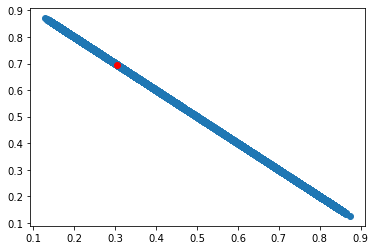

In [6]:
import matplotlib.pyplot as plt
pltX = [dot[0] for dot in Xvec]
pltY = [dot[1] for dot in Xvec]

newX,newY = lda.transform(test_vec)[0]
print(newX, newY)

plt.scatter(pltX,pltY)
plt.scatter(newX,newY,c="red")

## LDA with gensim

In [7]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaModel
from gensim.models.coherencemodel import CoherenceModel

texts = df["text"].str.split()
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [8]:
from tqdm import tqdm
models = []
for n in tqdm(range(10,32,2)):
    lda = LdaModel(corpus, num_topics=n)
    coherence = CoherenceModel(model = lda, texts = texts, dictionary = dictionary, coherence = 'c_v')
    models.append((n,lda,coherence,coherence.get_coherence()))
    print(models[-1][0], models[-1][-1])

  9%|▉         | 1/11 [00:02<00:21,  2.15s/it]

10 0.48835773667867394


 18%|█▊        | 2/11 [00:04<00:19,  2.12s/it]

12 0.5364666879385215


 27%|██▋       | 3/11 [00:06<00:18,  2.35s/it]

14 0.5636617838781992


 36%|███▋      | 4/11 [00:09<00:16,  2.41s/it]

16 0.5609078566092494


 45%|████▌     | 5/11 [00:12<00:14,  2.50s/it]

18 0.5778768060274913


 55%|█████▍    | 6/11 [00:14<00:12,  2.56s/it]

20 0.5844924048809809


 64%|██████▎   | 7/11 [00:17<00:10,  2.65s/it]

22 0.6063505055288764


 73%|███████▎  | 8/11 [00:20<00:08,  2.71s/it]

24 0.6019372400051822


 82%|████████▏ | 9/11 [00:23<00:05,  2.84s/it]

26 0.6043839481704245


 91%|█████████ | 10/11 [00:26<00:02,  2.94s/it]

28 0.6231038599502633


100%|██████████| 11/11 [00:30<00:00,  2.73s/it]

30 0.6250599746979083


In [9]:
for n,lda_model,coherence_model,score in models:
    print(n,score)

10 0.48835773667867394
12 0.5364666879385215
14 0.5636617838781992
16 0.5609078566092494
18 0.5778768060274913
20 0.5844924048809809
22 0.6063505055288764
24 0.6019372400051822
26 0.6043839481704245
28 0.6231038599502633
30 0.6250599746979083


In [10]:
import pyLDAvis.gensim
lda = models[-1][1]
print(lda)

lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics = False)
pyLDAvis.display(lda_display)

LdaModel<num_terms=12149, num_topics=30, decay=0.5, chunksize=2000>


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy